# Import Packages

In [6]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser

# Import & Process Data

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [11]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning
# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 20]
# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

In [12]:
print(filtered_data.shape)
filtered_data.head()

(18302, 16)


_id                 accountId  \
0  6220c8e159378700114a8722  61c5e725941a0600135559cf   
1  62c30db86daa10001266325e  6215fbb82c463a001166ad8f   
2  62e0fcf555577b00112d3176  625e873608ff4300110c62af   
4  62c44ba62e447d00129fc612  61c453eebcc5e4001133f68a   
5  62c5589f756f3f00119ec3b4  61c453eebcc5e4001133f68a   

                             customerId IMD_Decile                 createdAt  \
0  4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8          9  2022-03-03T13:55:45.434Z   
1  a4c47159-e445-4b31-8ea9-6c5852bd7095          8  2022-07-04T15:56:40.950Z   
2  b5a28615-7994-458e-8903-8086ac77eb49  Not_Found  2022-07-27T08:53:09.433Z   
4  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-05T14:33:10.080Z   
5  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-06T09:40:47.483Z   

  amount.currency  amount.exponent  amount.value  \
0             GBP                2          5067   
1             GBP                2          4600   
2             GBP                2          5000   
4             GBP                2           600   
5             GBP                2           600   

   externalParty.merchantCategoryCode externalParty.transactionCategory  \
0                                 742                             OTHER   
1                                 742                             OTHER   
2                                 742                             OTHER   
4                                1520                          SHOPPING   
5                                1520                          SHOPPING   

                                  MCC_List  \
0                      Veterinary Services   
1                      Veterinary Services   
2                      Veterinary Services   
4  General Contractor/Residential Building   
5  General Contractor/Residential Building   

   transactionFootPrint.carbonEmissionInGrams transactionType.code  \
0                                10048.033278           REDEMPTION   
1                                 9121.956400           REDEMPTION   
2                                 9915.170000           REDEMPTION   
4                                15224.930000           REDEMPTION   
5                                15224.930000           REDEMPTION   

  transactionType.direction  emission_rate     mcc_classification  
0                     DEBIT       1.944456  Agricultural Services  
1                     DEBIT       1.983033  Agricultural Services  
2                     DEBIT       1.983034  Agricultural Services  
4                     DEBIT      25.374883    Contracted Services  
5                     DEBIT      25.374883    Contracted Services

In [13]:
print('nunique customerId: '+str(filtered_data['customerId'].nunique()))
print('nunique mcc_code: '+str(filtered_data['externalParty.merchantCategoryCode'].nunique()))
print('nunique mcc_code: '+str(filtered_data['MCC_List'].nunique()))

nunique customerId: 236
nunique mcc_code: 194
nunique mcc_code: 194


In [14]:
# Create the CustomerID array
CustomerID = list(customer_mcc_dict.keys())

# Create the MCC array by zipping the two lists together
MCC = [customer_mcc_dict[customer_id] for customer_id in CustomerID]

# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))
print(len(CustomerID))

236


In [15]:
# Check if all values in CustomerID are unique
are_all_unique = len(CustomerID) == len(set(CustomerID))

if are_all_unique:
    print("All values in CustomerID are unique.")
else:
    print("There are duplicate values in CustomerID.")

All values in CustomerID are unique.


Check if the code does what we expect it to -- put a random value for a customer in i_doc and check if the list of MCC we get back is the same one as in the Excel file. Code works!

In [16]:
#Check for a random customer/MCC in Excel to make sure it is correct
i_doc = 102
print(CustomerID[i_doc])
print(MCC[i_doc][:10])

ea27dd28-fded-452f-bc14-c1ff02689d8d
['Passenger Rail (train)', 'Nurseries and Lawn and Garden Supply Stores\xa0', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Grocery Stores and Supermarkets', 'Miscellaneous Food Stores-Convenience Stores and Specialty Markets']


# Create Model and Plot

In [17]:
## Create the sbmtm model
model = sbmtm()

## we have to create the customer-MCC network from the data
model.make_graph(MCC,documents=CustomerID,counts=True)

model.g

<Graph object, undirected, with 430 vertices and 3464 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f0c9d2b9c40>

In [18]:
SEED = 41
gt.seed_rng(SEED) ## seed for graph-tool's random number generator --> same results

#fit the model
model.fit(n_init=100, verbose=False)

print('The lowest entropy was {}, and the state has {} blocks at level 0'.format(model.state.entropy(),model.state.get_levels()[0].get_nonempty_B()))
with open('./Results/minimized_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model,f)

18010.945798960973
17958.832856674107
18058.246405291215
17985.51965070633
18148.332242130396
18077.514089980552
17983.26468155194
18149.182912900244
18019.441523196318
17982.569714474095
18233.374273786
18154.1087821612
18038.09570323279
18131.586844724272
18335.72984626219
18159.175370261717
18290.7343362084
18113.970967273708
18057.78229695186
18110.664530400467
18146.89229993534
18060.187554963064
18081.5664473827
18007.502132944566
18043.932056176487
18132.837963492268
18103.89813857891
17978.324402792518
18371.696030836563
18183.63847128022
18189.38471886458
18064.67070686133
18363.44795587773
18165.168876935095
18116.692325613607
18095.620105302933
18192.00384162295
18264.668675697816
18196.46316694971
18015.20115016385
18099.587134987916
18401.228014220498
18077.37433572915
17947.658006857717
18069.093260065107
18278.610100662667
18114.96957182006
17985.943351596015
18156.42145560941
18101.4369297957
18077.596111962877
18010.417495199767
18218.834865793753
18123.072349980917
18

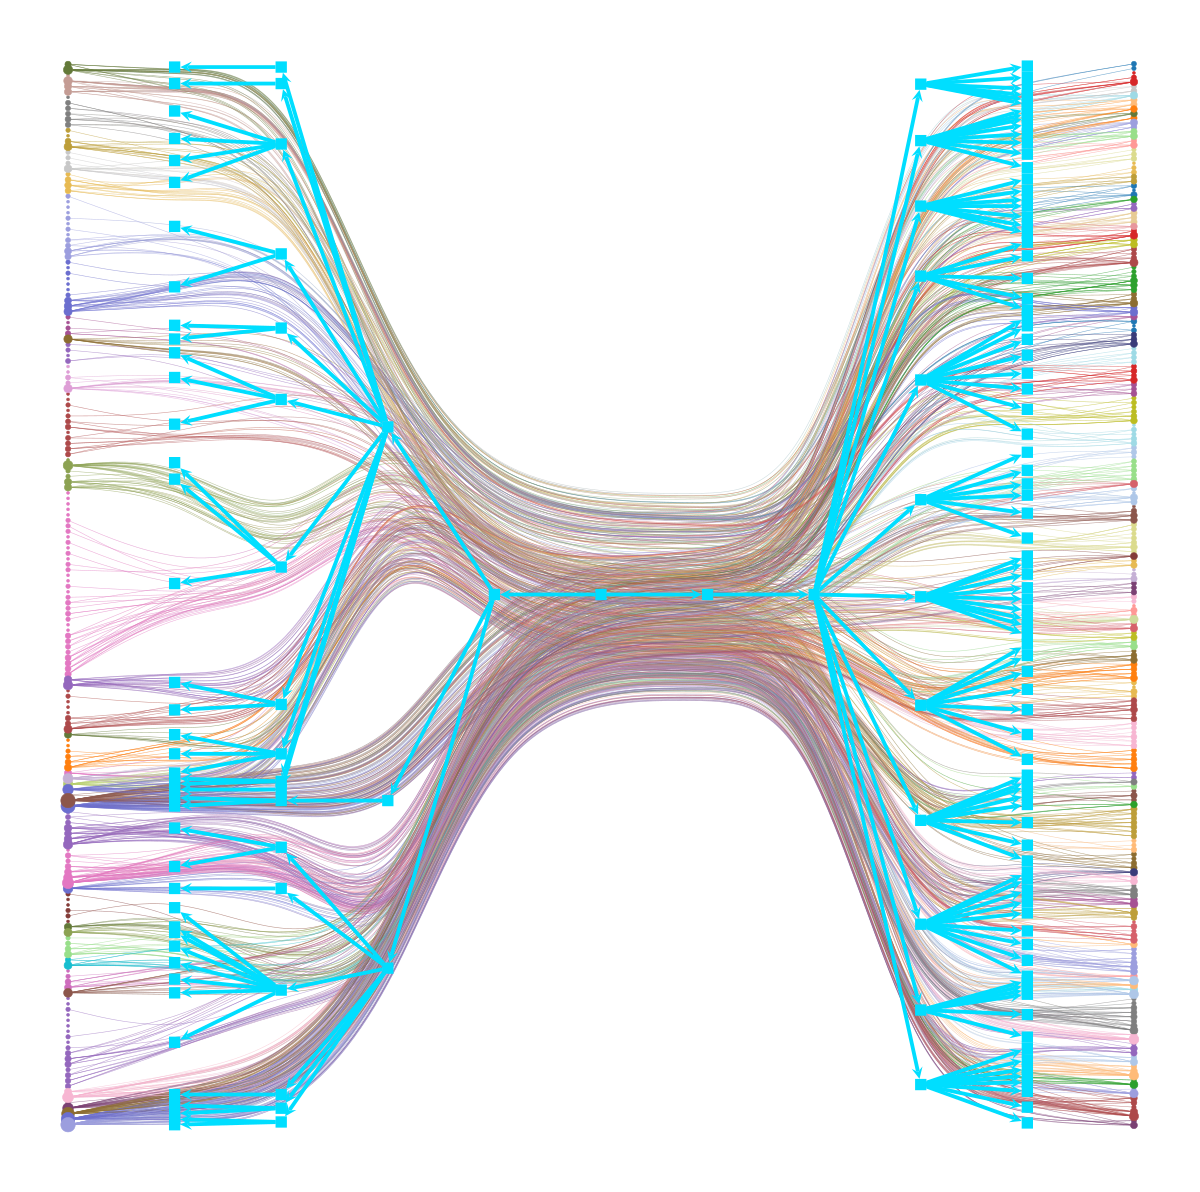

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0c9d2b9c40, at 0x7f0c9d898e30>,
 <GraphView object, directed, with 596 vertices and 595 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0c9d89b890, at 0x7f0c9a2a87d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0c9d89b890, at 0x7f0c9d899d30>, False), at 0x7f0c9d89b890>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0c9d89b890, at 0x7f0c9d898c20>)

In [19]:
#Plot
model.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [20]:
with open("./Results/minimized_model_seed_{}.pkl".format(SEED), "rb") as f:
        model_100 = pickle.load(f)
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 129 blocks at level 0, 30 at level 1, and its entropy is entropy: 17837.27


further sweep with the multiflip_mcmc just in case we got stuck in a bad local minimum

In [21]:
starting_entropy=model_100.state.entropy()
entropy_gain_multiflip=[model_100.state.multiflip_mcmc_sweep(beta=np.inf, niter=10)[0] for i in range(1000)]

In [22]:
model_100.state.entropy()

17081.740130694692

In [24]:
entropy_diff = np.cumsum(np.array(entropy_gain_multiflip))
entropy_diff_positive = -entropy_diff
# entropy_exp_10 = entropy_diff_positive/(np.log(2)+np.log(5))
# entropy_likelihood = np.power(10,entropy_exp_10)

In [61]:
with open('./Results/entropy_likelihood.pkl','wb') as f:
    pickle.dump(entropy_likelihood,f)

In [62]:
with open('./Results/multiflip_mcmc_model_seed_{}.pkl'.format(SEED),'wb') as f:
    pickle.dump(model_100,f)

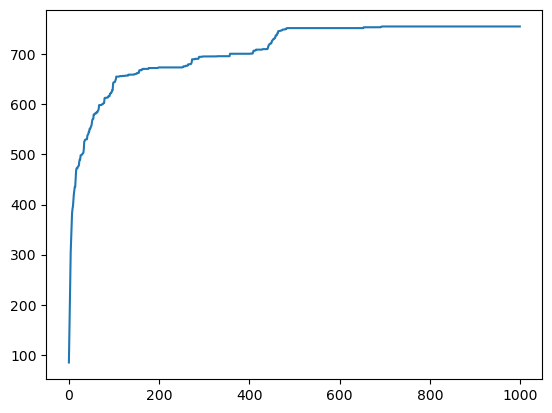

In [25]:
plt.plot(entropy_diff_positive)

clustering result after MCMC

In [26]:
print('This state has {} blocks at level 0, {} at level 1, and its entropy is entropy: {:.2f}'.format(model_100.state.get_levels()[0].get_nonempty_B(),model_100.state.get_levels()[1].get_nonempty_B(),model_100.state.entropy()))

This state has 145 blocks at level 0, 34 at level 1, and its entropy is entropy: 17081.74


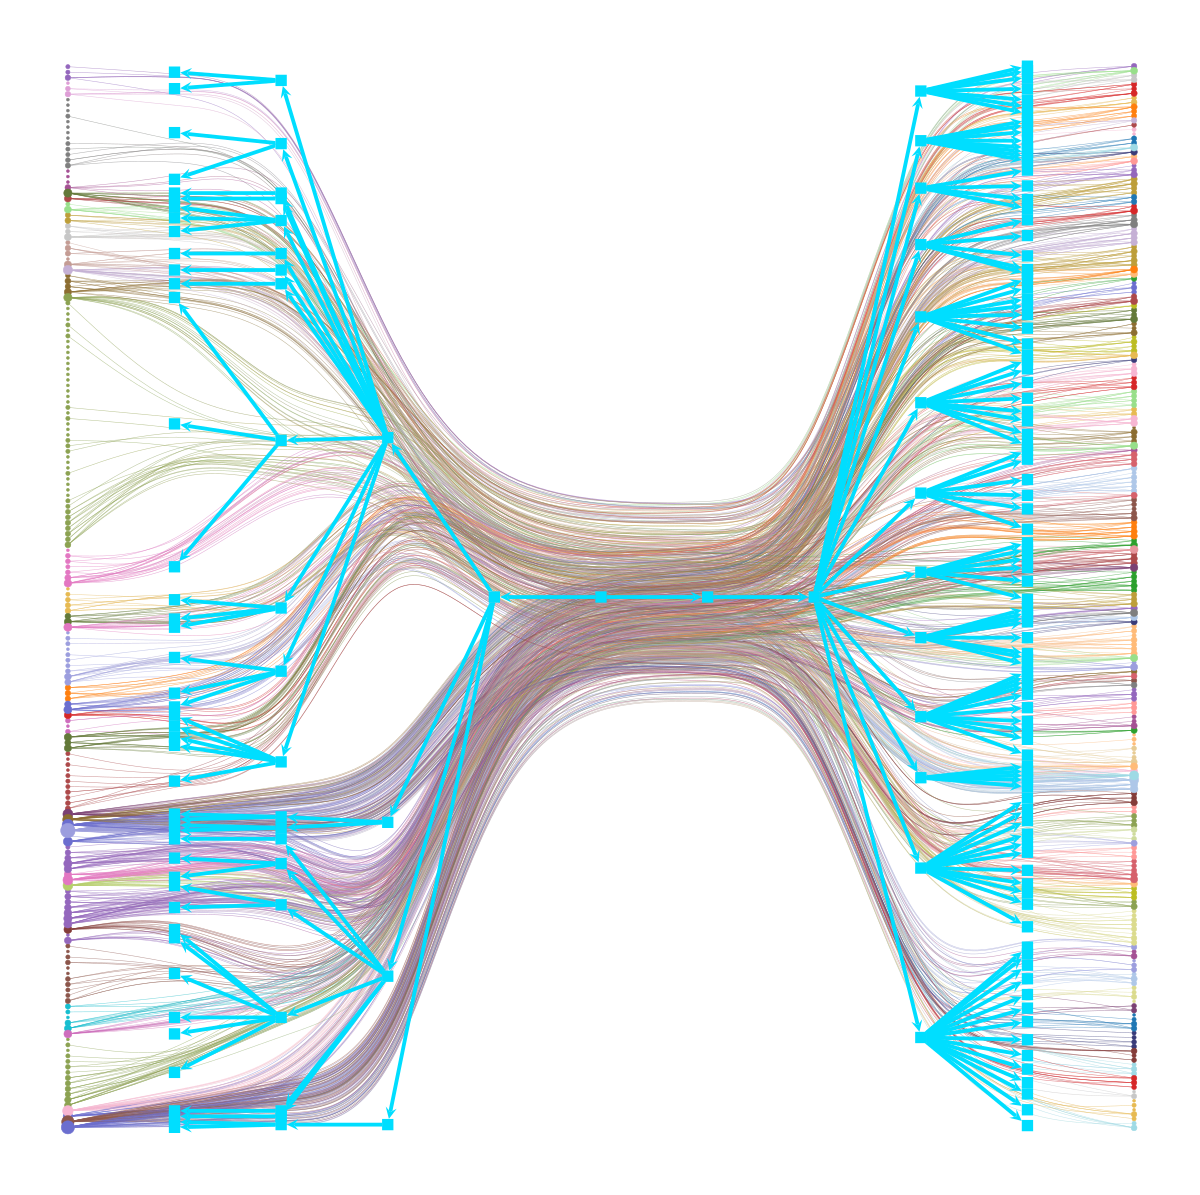

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0c9d898d40, at 0x7f0c9cf50740>,
 <GraphView object, directed, with 617 vertices and 616 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0c9d1b3d10, at 0x7f0c9d1b3230>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0c9d1b3d10, at 0x7f0c9d1b3110>, False), at 0x7f0c9d1b3d10>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0c9d1b3d10, at 0x7f0d5646c8c0>)

In [27]:
#Plot
model_100.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [28]:
# get the cluster at different levels
levels = model_100.state.get_levels()
for i in range(3):
    print('Level',i)
    print('The lowest entropy was {}, and the state has {} blocks at level {}'.format(levels[i].entropy(),levels[i].get_nonempty_B(),i))
    print('The number of edges between blocks is {}'.format(levels[i].get_matrix().nnz))
    print('The number of edges within blocks is {}'.format(levels[i].get_matrix().sum()))

Level 0
The lowest entropy was 27805.823586792387, and the state has 145 blocks at level 0
The number of edges between blocks is 3952
The number of edges within blocks is 36604.0
Level 1
The lowest entropy was 16488.58766622345, and the state has 34 blocks at level 1
The number of edges between blocks is 498
The number of edges within blocks is 36604.0
Level 2
The lowest entropy was 8048.299035435006, and the state has 5 blocks at level 2
The number of edges between blocks is 8
The number of edges within blocks is 36604.0


In [29]:
model_100.get_groups(l=1)

{'Bd': 13,
 'Bw': 21,
 'p_tw_w': array([[1., 0., 0., ..., 1., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'p_td_d': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'p_w_tw': array([[0.00742574, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00854701, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00247525, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00247525, 0.        , 0.        , ..., 0. 

In [30]:
len(model_100.clusters(l=1))

13

In [31]:
# get the number of documents in each topic(cluster) at level 1
# model.clusters(l=1)
# print the number of documents in each topic(cluster) at level 1
x = 0
for i in range(len(model_100.clusters(l=1))):
    x += len(model_100.clusters(l=1,n=100)[i])
    print('The number of documents in topic {} is {}'.format(i+1,len(model_100.clusters(l=1,n=100)[i])))
print('The total number of documents is {}'.format(x))

The number of documents in topic 1 is 20
The number of documents in topic 2 is 6
The number of documents in topic 3 is 18
The number of documents in topic 4 is 14
The number of documents in topic 5 is 14
The number of documents in topic 6 is 20
The number of documents in topic 7 is 34
The number of documents in topic 8 is 12
The number of documents in topic 9 is 15
The number of documents in topic 10 is 11
The number of documents in topic 11 is 21
The number of documents in topic 12 is 41
The number of documents in topic 13 is 10
The total number of documents is 236


<Axes: >

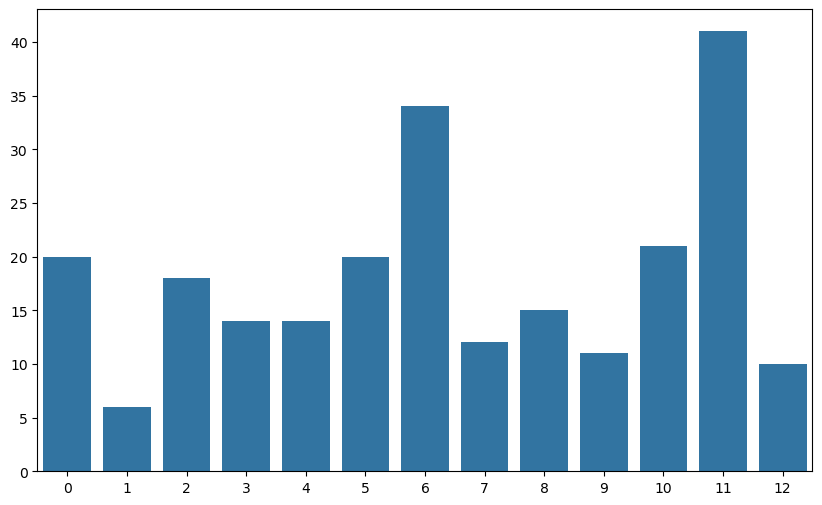

In [32]:
# plot the number of documents in each topic(cluster) at level 1, labeled by the topic(cluster) number
plt.figure(figsize=(10,6))
sns.barplot([len(model_100.clusters(l=1,n=100)[i]) for i in range(len(model_100.clusters(l=1)))])

# Model Analysis

In [33]:
Customer_clusters = model_100.clusters(l=1,n=1000).items()
Customer_clusters = [[id for id, p in cluster] for i, cluster in Customer_clusters]
Customer_clusters

[['c3924705-b945-49a4-8cfd-00ac0e28b4ff',
  '878a2bdf-a03e-4a90-99f7-cc562b2596a8',
  '72a0cb8b-f9d3-40a9-a54d-00931a871fde',
  '7672be30-6f0e-4e7d-8db7-437b8bfaaac1',
  '55090843-958b-4c8a-8f81-a8bf2809738a',
  'fccc649d-a523-4f39-bc66-1e46a8ced7e5',
  '55203a37-2196-40d6-90f6-19b3be2e1eae',
  '767201c1-4dc1-46c3-a2c2-fd75e44504ae',
  '46ead12d-66f0-4f0f-9307-80b3096216be',
  'e1b4b770-75c2-40c7-a396-e08629428241',
  '79d37749-df15-491e-a395-74e1ac756fbe',
  '0c922076-e434-411a-8a3e-1c06b00979f4',
  '2c26e6f7-b19d-4974-8052-8ee4ff93cda9',
  '01ef943c-d661-48b0-9c0b-bb456a7d998d',
  '0ae40402-f81b-4ce1-801f-94246b674aef',
  '712923fa-b62f-46e8-a352-c5656ee10894',
  '4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8',
  '163bc397-16ad-4166-b442-17332c4ae677',
  'd37e054b-e800-4d7e-9ca4-a62c6f1b9a72',
  'c22cab43-3233-4fef-9548-561f03b4bb74'],
 ['40145ab5-241c-47c5-bb6a-3a05374b28a9',
  'e1090e22-632f-45e4-a480-b9206b3a573d',
  '886926ad-2f76-4746-a7fc-ca1473c848a3',
  '2aa2a980-470d-470a-8379-ec51e5

In [34]:
l0 = model_100.clusters(l=0,n=1000).items()
l0 = [(id, i) for i, cluster in l0 for id, p in cluster]
df_clusters = pd.DataFrame(l0, columns=['CustomerID', 'level_0'])
l1 = model_100.clusters(l=1,n=1000).items()
l1 = [(id, i) for i, cluster in l1 for id, p in cluster]
df_clusters = pd.merge(df_clusters, pd.DataFrame(l1, columns=['CustomerID', 'level_1']))
l2 = model_100.clusters(l=2,n=1000).items()
l2 = [(id, i) for i, cluster in l2 for id, p in cluster]
df_clusters = pd.merge(df_clusters, pd.DataFrame(l2, columns=['CustomerID', 'level_2']))
df_clusters['level'] = df_clusters.apply(lambda x: str(x['level_1'])+'_'+str(x['level_0']), axis=1)
df_clusters.sort_values(by=['level_1', 'level_0'], ascending=[True, True], inplace=True)
df_clusters.reset_index(drop=True, inplace=True)
df_clusters

CustomerID  level_0  level_1  level_2  level
0    4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8        0        0        0    0_0
1    712923fa-b62f-46e8-a352-c5656ee10894        4        0        0    0_4
2    d37e054b-e800-4d7e-9ca4-a62c6f1b9a72        4        0        0    0_4
3    79d37749-df15-491e-a395-74e1ac756fbe        4        0        0    0_4
4    163bc397-16ad-4166-b442-17332c4ae677        4        0        0    0_4
..                                    ...      ...      ...      ...    ...
231  be6d74ea-4bb2-4424-b537-d34873554e72       67       12        0  12_67
232  ea27dd28-fded-452f-bc14-c1ff02689d8d       69       12        0  12_69
233  c51f1c46-a98c-43cd-a252-5e566b228055       76       12        0  12_76
234  ae54b0a2-7ad3-432c-ae1b-040e9365f8ee       76       12        0  12_76
235  e9ce12f2-9112-415a-a6fd-b72f0bcc83ec       91       12        0  12_91

[236 rows x 5 columns]

## Calculate the CO2 emissions per GBP for clusters

In [35]:
def calculate_CO2_to_amount_ratio(customer_cluster, df):
    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df[df['customerId'].isin(customer_cluster)]
    
    # Sum up the total CO2 emissions and total amount spent for the cluster
    total_CO2 = cluster_data['Total_CO2_Emissions'].sum()
    total_amount_spent = cluster_data['Total_Amount_Spent'].sum()
    
    # Calculate the ratio of CO2 emissions to the amount spent
    if total_amount_spent != 0:
        ratio = total_CO2 / total_amount_spent
    else:
        ratio = 0.0
    
    return ratio

Length = []
ClusterCO2_ratio = []

for i, cluster in enumerate(Customer_clusters):
    # Calculate the CO2 to amount spent ratio for the current cluster
    ratio = calculate_CO2_to_amount_ratio(cluster, df)
    
    # Append cluster length and CO2 to amount spent ratio to lists
    Length.append(len(cluster))
    ClusterCO2_ratio.append(ratio)
    
    # Print the results
    print(f"The customer cluster {i+1} has {Length[i]} customers and the CO2 emissions to amount spent ratio for it is {ClusterCO2_ratio[i]}")

# Calculate average age for each cluster
ClusterAvgAge = [calculate_average_age_and_IMD(i, customer_data_cleaned, Customer_clusters)[0] for i in range(len(Customer_clusters))]

# Scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figsize as needed
plt.scatter(ClusterAvgAge, ClusterCO2_ratio, color='blue', marker='o')

# Annotate each point with the cluster number
for i, (age, ratio) in enumerate(zip(ClusterAvgAge, ClusterCO2_ratio)):
    plt.text(age, ratio, f'Cluster {i+1}', fontsize=9, ha='center', va='top')

plt.title('Scatter Plot of Average Age vs. CO2 Emissions to Amount Spent Ratio')
plt.xlabel('Average Age of Customers in Cluster')
plt.ylabel('CO2 Emissions to Amount Spent Ratio')
plt.grid(True)
plt.show()

# Calculate average IMD_Rank for each cluster
ClusterAvgIMD = [calculate_average_age_and_IMD(i, customer_data_cleaned, Customer_clusters)[1] for i in range(len(Customer_clusters))]

# Scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figsize as needed
plt.scatter(ClusterAvgIMD, ClusterCO2_ratio, color='blue', marker='o')

# Annotate each point with the cluster number
for i, (imd, ratio) in enumerate(zip(ClusterAvgIMD, ClusterCO2_ratio)):
    plt.text(imd, ratio, f'Cluster {i+1}', fontsize=9, ha='center', va='top')

plt.title('Scatter Plot of Average IMD Rank vs. CO2 Emissions to Amount Spent Ratio')
plt.xlabel('Average IMD Rank of Customers in Cluster')
plt.ylabel('CO2 Emissions to Amount Spent Ratio')
plt.grid(True)
plt.show()

KeyError: 'Total_CO2_Emissions'

## IMD and Age by clusters

In [36]:
df_imd = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='IMD_Rank')
df_customer = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='ekko_customer_info')
print('Before dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_imd.dropna(inplace=True)
df_imd.reset_index(drop=True, inplace=True)
df_customer.dropna(inplace=True)
df_customer.reset_index(drop=True, inplace=True)
print('After dropping NaN values:')
print(df_imd.shape)
print(df_customer.shape)
df_customer.head()

Before dropping NaN values:
(874, 28)
(12986, 6)
After dropping NaN values:
(874, 28)
(11931, 6)


Sender_customer_Id address.postcode address.townOrCity  \
0  eecbba00-41c0-4111-ae83-286a302fed0c          NW1 9DR             London   
1  dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad          SM2 6DU             Sutton   
2  bb10d50e-5e6a-43c2-bd6d-323b7d9c731f          SW1W0NY             London   
3  5c0a9926-a3b5-4441-945b-c1f619ed339a           SM25HT             Sutton   
4  12ea2e69-cea2-4e47-9d21-55402dd47811          SW1W0NY             London   

                  createdAt               dateOfBirth     nationality  
0  2021-11-04T12:46:07.257Z  1995-05-21T00:00:00.000Z  United Kingdom  
1  2021-12-09T18:04:46.294Z  1981-10-30T00:00:00.000Z  United Kingdom  
2  2021-12-15T11:41:54.937Z  1991-04-11T00:00:00.000Z  United Kingdom  
3  2021-12-15T13:33:27.821Z  1986-05-22T00:00:00.000Z  United Kingdom  
4  2021-12-15T14:31:52.354Z  1991-04-11T00:00:00.000Z  United Kingdom

In [37]:
# calculate the age of the customers
df_customer['age'] = df_customer.apply(lambda x: 2024 - parser.parse(x['dateOfBirth']).year, axis=1)
df_customer.head()

Sender_customer_Id address.postcode address.townOrCity  \
0  eecbba00-41c0-4111-ae83-286a302fed0c          NW1 9DR             London   
1  dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad          SM2 6DU             Sutton   
2  bb10d50e-5e6a-43c2-bd6d-323b7d9c731f          SW1W0NY             London   
3  5c0a9926-a3b5-4441-945b-c1f619ed339a           SM25HT             Sutton   
4  12ea2e69-cea2-4e47-9d21-55402dd47811          SW1W0NY             London   

                  createdAt               dateOfBirth     nationality  age  
0  2021-11-04T12:46:07.257Z  1995-05-21T00:00:00.000Z  United Kingdom   29  
1  2021-12-09T18:04:46.294Z  1981-10-30T00:00:00.000Z  United Kingdom   43  
2  2021-12-15T11:41:54.937Z  1991-04-11T00:00:00.000Z  United Kingdom   33  
3  2021-12-15T13:33:27.821Z  1986-05-22T00:00:00.000Z  United Kingdom   38  
4  2021-12-15T14:31:52.354Z  1991-04-11T00:00:00.000Z  United Kingdom   33

In [38]:
df_imd['age'] = df_imd['CustomerId'].map(df_customer.set_index('Sender_customer_Id')['age'])
df_imd.head()

CustomerId  Index_of_Multiple_Deprivation_Decile  \
0  db9b8ecb-173d-43fb-bff6-b7f7b54b603b                                     3   
1  60614561-6838-4200-a37c-978cdffad096                                     2   
2  886926ad-2f76-4746-a7fc-ca1473c848a3                                     9   
3  55929e08-6995-4766-ad89-402bb47358f8                                     4   
4  ae54b0a2-7ad3-432c-ae1b-040e9365f8ee                                     7   

  Postcode_Status  LSOA_code                   LSOA_Name  \
0            Live  E01010959   Calderdale 020D E01010959   
1            Live  E01011043     Kirklees 031B E01011043   
2            Live  E01004694  Westminster 016C E01004694   
3            Live  E01027498     Tynedale 005B E01027498   
4            Live  E01001642    Greenwich 038C E01001642   

   Index_of_Multiple_Deprivation_Rank  Income_Rank  Income_Decile  \
0                                8106         7040              3   
1                                5947         6529              2   
2                               26491        31488             10   
3                               12152         8097              3   
4                               22742        26579              9   

   Income_Score  Employment_Rank  ...  \
0         0.194             5093  ...   
1         0.202             6750  ...   
2         0.026            32231  ...   
3         0.179             9178  ...   
4         0.048            30198  ...   

   Barriers_to_Housing_and_Services_Decile  Living_Environment_Rank  \
0                                       10                     9666   
1                                        5                     1975   
2                                        3                     5526   
3                                        8                    32328   
4                                        6                     6012   

   Living_Environment_Decile  IDACI_Rank  IDACI_Decile  IDACI_Score  \
0                          3        6327             2        0.260   
1                          1        9700             3        0.206   
2                          2       32013            10        0.019   
3                         10        9016             3        0.216   
4                          2       21946             7        0.082   

   IDAOPI_Rank  IDAOPI_Decile  IDAOPI_Score   age  
0        12134              4         0.172  29.0  
1         3799              2         0.324  26.0  
2        19729              7         0.102  27.0  
3         7387              3         0.241  28.0  
4        25719              8         0.067  56.0  

[5 rows x 29 columns]

In [39]:
def calculate_average_age_and_IMD(cluster_index, df_imd, clusters):
    # Get the customer IDs in the specified cluster
    customer_cluster = clusters[cluster_index]

    # Filter the DataFrame to include only customers in the current cluster
    cluster_data = df_imd[df_imd['CustomerId'].isin(customer_cluster)]
    
    # Calculate the average age and IMD_Rank for the cluster
    average_age = cluster_data['age'].mean()
    average_IMD = cluster_data['Index_of_Multiple_Deprivation_Decile'].mean()
    
    return average_age, average_IMD
customer_data_cleaned = df_imd
# Example usage:
for index in range(len(Customer_clusters)):
    cluster_index = index  # Replace this with the desired cluster index
    avg_age, avg_IMD = calculate_average_age_and_IMD(cluster_index, customer_data_cleaned, Customer_clusters)
    print(f"For cluster {cluster_index + 1}, the average age is {avg_age:.2f} and the average IMD_Rank is {avg_IMD:.2f}")


For cluster 1, the average age is 32.27 and the average IMD_Rank is 3.53
For cluster 2, the average age is 39.00 and the average IMD_Rank is 8.20
For cluster 3, the average age is 28.79 and the average IMD_Rank is 2.43
For cluster 4, the average age is 45.82 and the average IMD_Rank is 7.25
For cluster 5, the average age is 31.62 and the average IMD_Rank is 4.36
For cluster 6, the average age is 31.53 and the average IMD_Rank is 3.20
For cluster 7, the average age is 24.77 and the average IMD_Rank is 3.74
For cluster 8, the average age is 34.90 and the average IMD_Rank is 4.40
For cluster 9, the average age is 34.70 and the average IMD_Rank is 4.18
For cluster 10, the average age is 27.60 and the average IMD_Rank is 4.30
For cluster 11, the average age is 36.81 and the average IMD_Rank is 6.17
For cluster 12, the average age is 27.09 and the average IMD_Rank is 3.85
For cluster 13, the average age is 33.57 and the average IMD_Rank is 6.50


## Heatmaps of Purchases by Cluster

### calculating the relative importance

In [40]:
# calculate the idf of each MCC
# count the number of customers that have a specific MCC
df_mcc = filtered_data.groupby('MCC_List')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_mcc['idf'] = np.log(len(CustomerID)/df_mcc['nunique_customers'])
df_mcc = df_mcc.set_index('MCC_List')
df_mcc['proportion'] = filtered_data['MCC_List'].value_counts(normalize=True)
df_mcc.head()

nunique_customers  \
MCC_List                                                                
Grocery Stores and Supermarkets                                   213   
Eating Places and Restaurants                                     199   
Quick Payment Service-Fast Food Restaurants                       193   
Miscellaneous Food Stores-Convenience Stores an...                175   
Financial Institutions--Automated Cash Disburse...                142   

                                                         idf  proportion  
MCC_List                                                                  
Grocery Stores and Supermarkets                     0.102540    0.209868  
Eating Places and Restaurants                       0.170527    0.129986  
Quick Payment Service-Fast Food Restaurants         0.201142    0.061032  
Miscellaneous Food Stores-Convenience Stores an...  0.299046    0.060267  
Financial Institutions--Automated Cash Disburse...  0.508005    0.056770

In [41]:
# calculate the idf of each category
# count the number of customers that have a specific category
df_category = filtered_data.groupby('externalParty.transactionCategory')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_category['idf'] = np.log(len(CustomerID)/df_category['nunique_customers'])
df_category = df_category.set_index('externalParty.transactionCategory')
df_category['proportion'] = filtered_data['externalParty.transactionCategory'].value_counts(normalize=True)
df_category

nunique_customers       idf  proportion
externalParty.transactionCategory                                         
LIFESTYLE                                        227  0.038882    0.271118
GROCERIES                                        222  0.061154    0.276746
TRAVEL                                           209  0.121498    0.182439
SHOPPING                                         209  0.121498    0.149437
OTHER                                            205  0.140822    0.119987
FUEL                                               3  4.365220    0.000273

In [42]:
# calculate the idf of each classification
# count the number of customers that have a specific classification
df_classification = filtered_data.groupby('mcc_classification')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_classification['idf'] = np.log(len(CustomerID)/df_classification['nunique_customers'])
df_classification = df_classification.set_index('mcc_classification')
df_classification['proportion'] = filtered_data['mcc_classification'].value_counts(normalize=True)
df_classification

nunique_customers  \
mcc_classification                                                      
Miscellaneous Stores                                              233   
Retail Outlet Services                                            227   
Travel                                                            174   
Business Services                                                 121   
Clothing Stores                                                    99   
Utility Services                                                   81   
Professional Services and Membership Organizations                 77   
Government Services                                                53   
Agricultural Services                                               3   
Contracted Services                                                 2   

                                                         idf  proportion  
mcc_classification                                                        
Miscellaneous Stores                                0.012793    0.422631  
Retail Outlet Services                              0.038882    0.351929  
Travel                                              0.304777    0.131680  
Business Services                                   0.668041    0.035078  
Clothing Stores                                     0.868712    0.016173  
Utility Services                                    1.069383    0.015517  
Professional Services and Membership Organizations  1.120026    0.019943  
Government Services                                 1.493540    0.006666  
Agricultural Services                               4.365220    0.000164  
Contracted Services                                 4.770685    0.000219

In [43]:
df = filtered_data

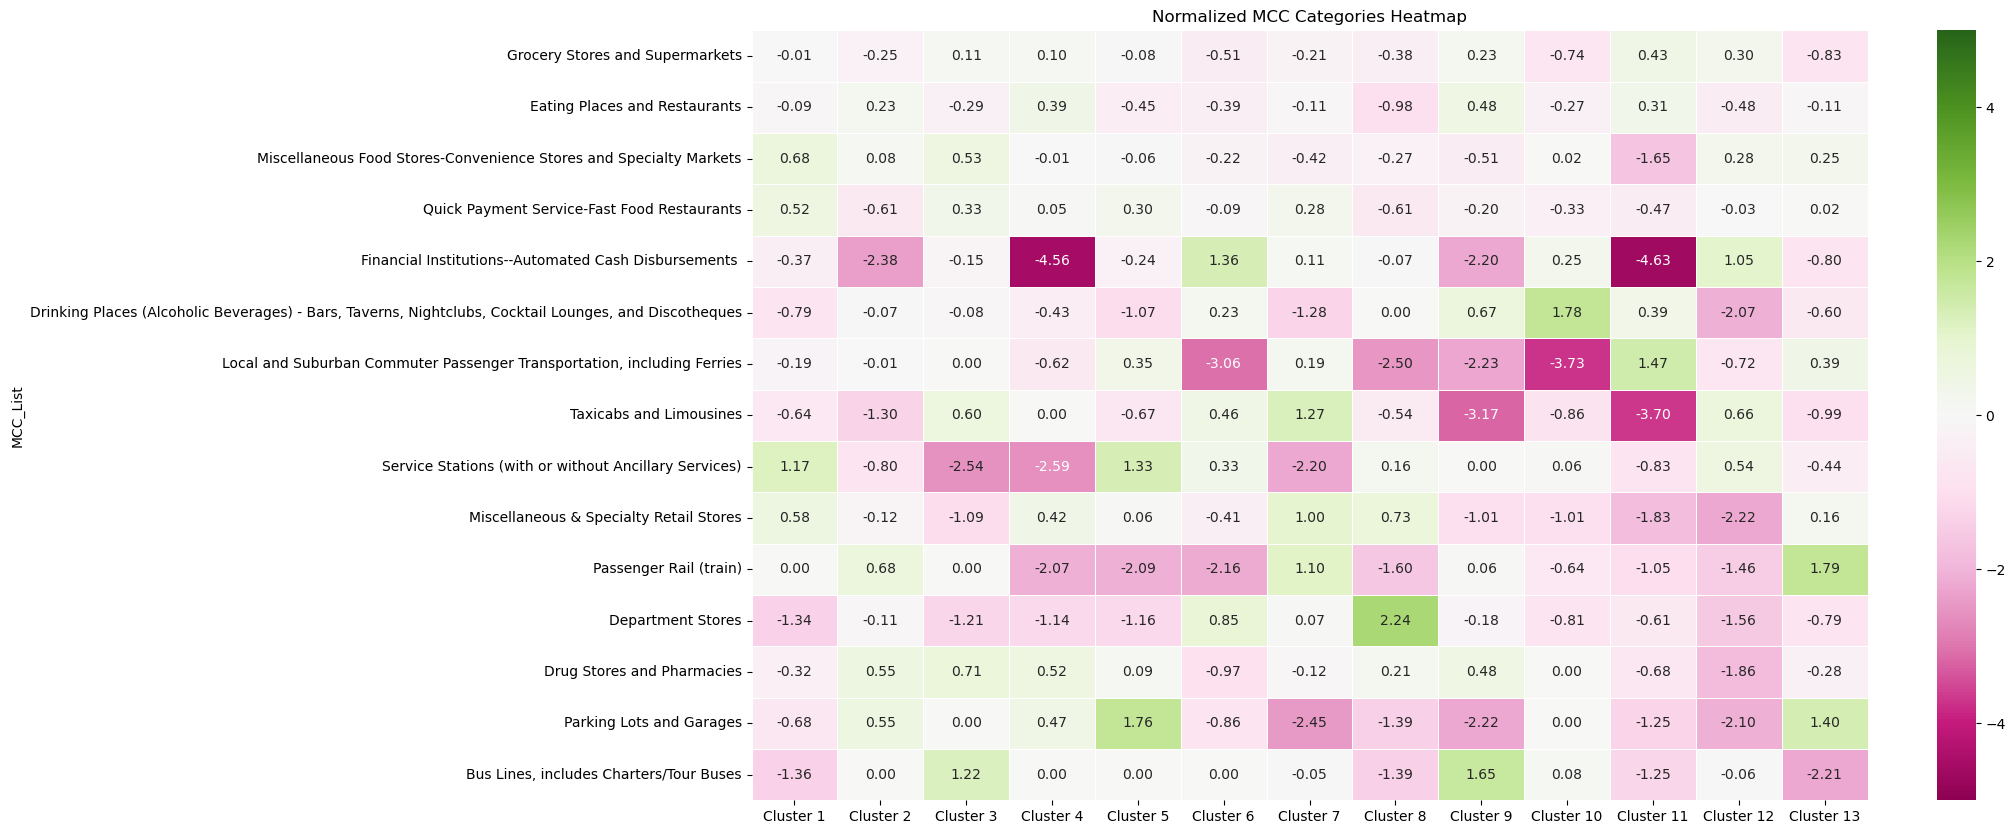

In [44]:
def mcc_heatmap_relative(clusters, df):
    cluster_counts = []
    cluster_counts_relative = []
    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        # calculate tfidf of each MCC
        mcc_counts_normalized = filtered_df['MCC_List'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        mcc_counts_relative = np.log(filtered_df['MCC_List'].value_counts(normalize=True) / df_mcc['proportion']).rename(f'Cluster {i + 1}')
        # mcc_counts_relative = filtered_df['MCC_List'].value_counts(normalize=True).rename(f'Cluster {i + 1}') / df_mcc['proportion']
        cluster_counts.append(mcc_counts_normalized)
        cluster_counts_relative.append(mcc_counts_relative)

    # Combine the normalized counts into a single DataFrame
    mcc_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    mcc_df_relative = pd.concat(cluster_counts_relative, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = mcc_df_normalized.sum(axis=1).nlargest(15).index

    # Filter the DataFrame to keep only the top categories
    mcc_top_df_normalized = mcc_df_relative.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(mcc_top_df_normalized, cmap='PiYG', annot=True, fmt='.2f', linewidths=.5, vmin=-5, vmax=5)
    # sns.heatmap(mcc_top_df_normalized, cmap='seismic', annot=True, fmt='.2f', linewidths=.5, vmin=-5, vmax=5)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

mcc_heatmap_relative(Customer_clusters, df)

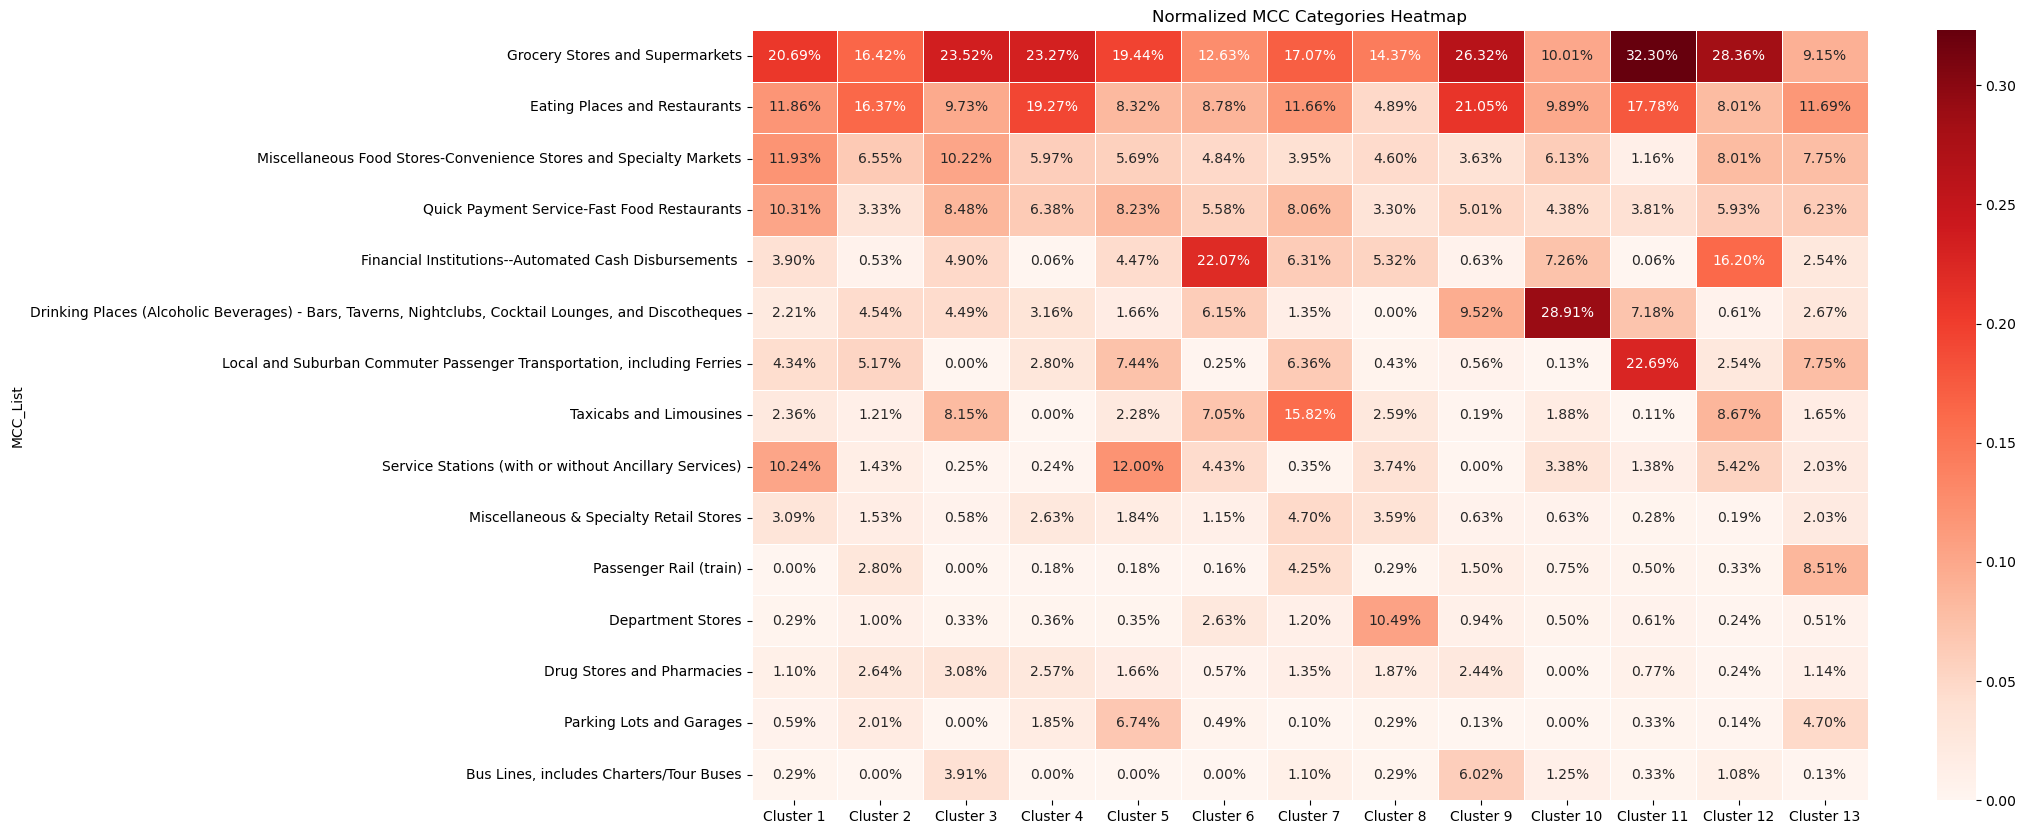

In [45]:
def mcc_heatmap_normalized(clusters, df):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        mcc_counts_normalized = filtered_df['MCC_List'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cluster_counts.append(mcc_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    mcc_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = mcc_df_normalized.sum(axis=1).nlargest(15).index

    # Filter the DataFrame to keep only the top categories
    mcc_top_df_normalized = mcc_df_normalized.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(mcc_top_df_normalized, cmap='Reds', annot=True, fmt='.2%', linewidths=.5)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

mcc_heatmap_normalized(Customer_clusters, df)

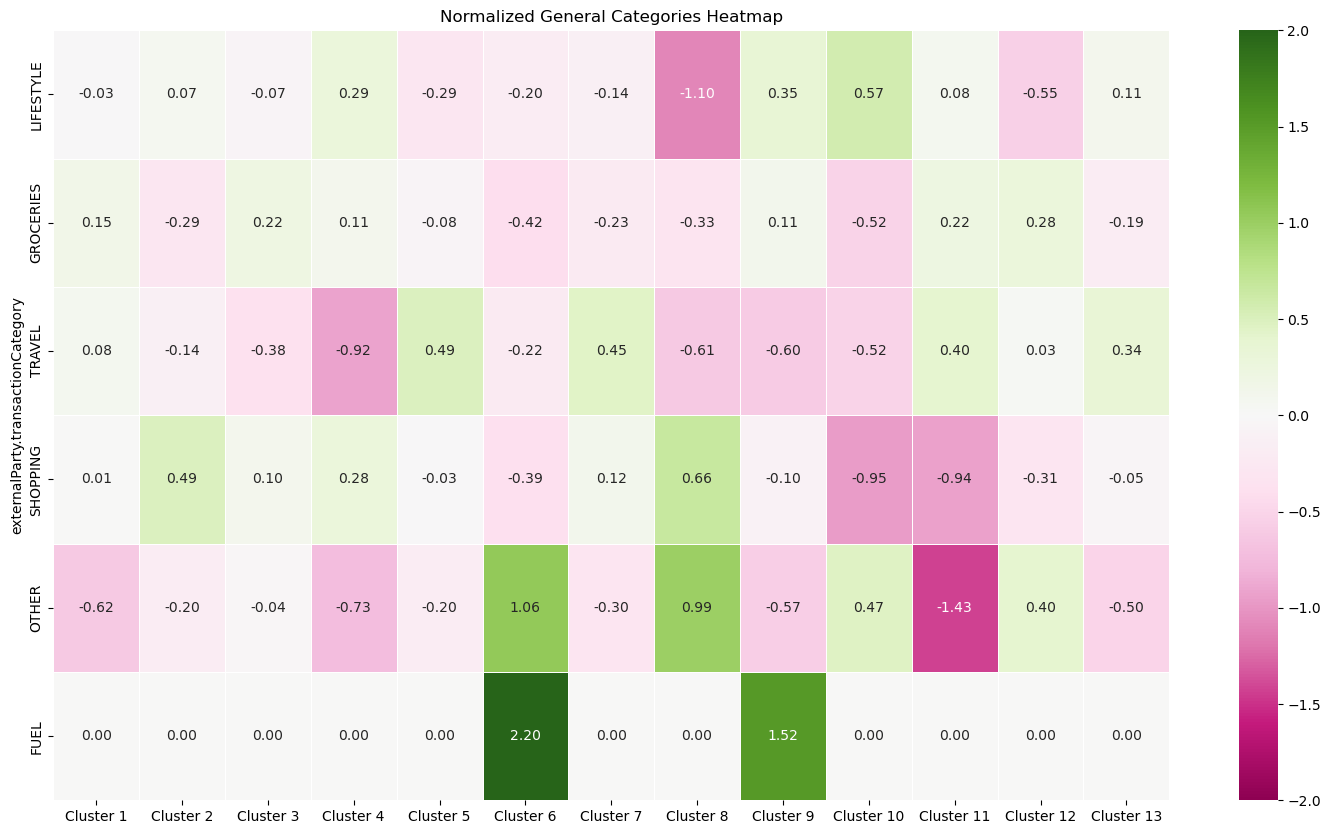

In [46]:
df = filtered_data
def cate_heatmap_relative(clusters, df):
    cluster_counts = []
    cluster_counts_relative = []
    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        cate_counts_normalized = filtered_df['externalParty.transactionCategory'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cate_counts_relative = np.log(filtered_df['externalParty.transactionCategory'].value_counts(normalize=True)/df_category['proportion']).rename(f'Cluster {i + 1}')
        cluster_counts.append(cate_counts_normalized)
        cluster_counts_relative.append(cate_counts_relative)

    # Combine the normalized counts into a single DataFrame
    cate_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    cate_df_relative = pd.concat(cluster_counts_relative, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = cate_df_normalized.sum(axis=1).nlargest(6).index

    # Filter the DataFrame to keep only the top categories
    cate_top_df_normalized = cate_df_relative.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(cate_top_df_normalized, cmap='PiYG', annot=True, fmt='.2f', linewidths=.5, vmin=-2, vmax=2)
    plt.title('Normalized General Categories Heatmap')
    plt.show()

cate_heatmap_relative(Customer_clusters, df)

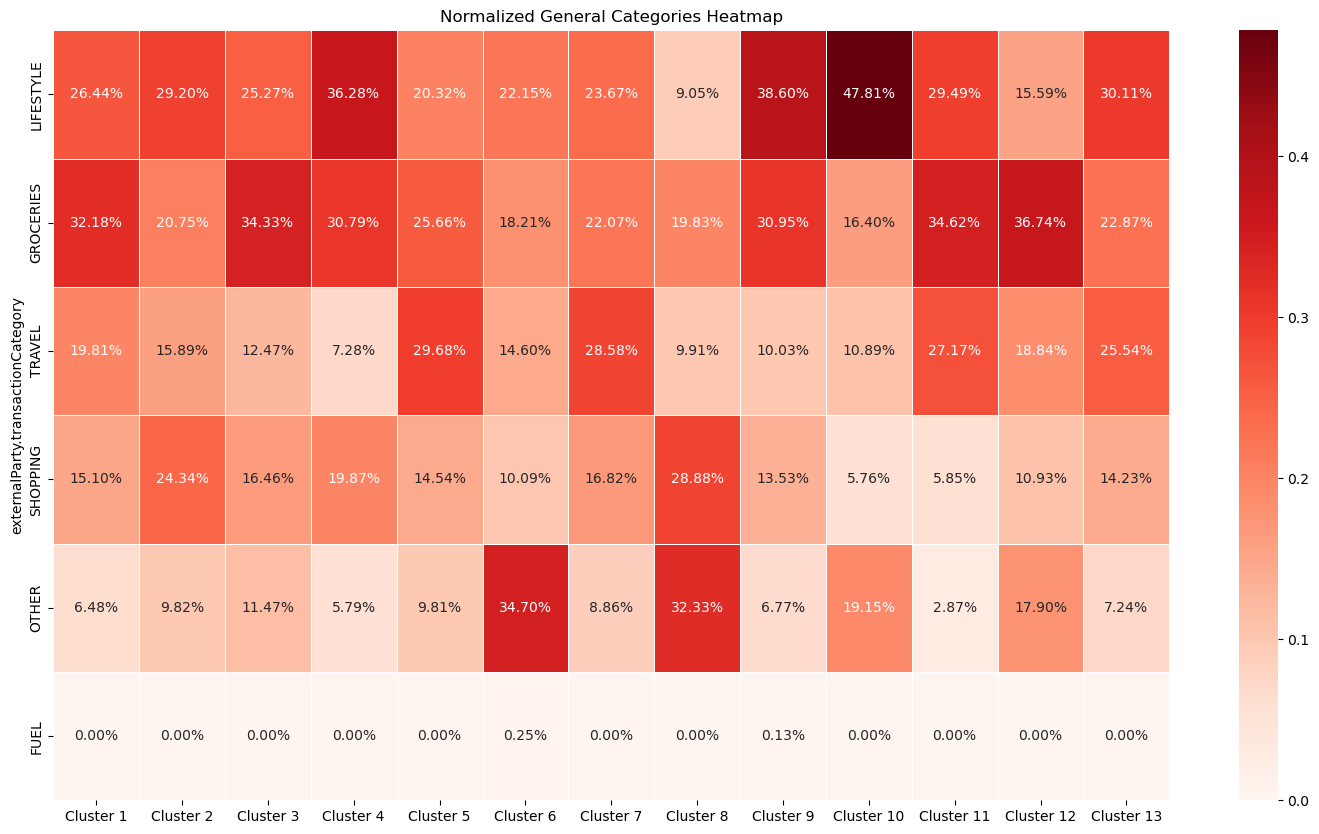

In [47]:
df = filtered_data
def cate_heatmap_normalized(clusters, df):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for i, cluster in enumerate(clusters):
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['customerId'].isin(cluster)]
        cate_counts_normalized = filtered_df['externalParty.transactionCategory'].value_counts(normalize=True).rename(f'Cluster {i + 1}')
        cluster_counts.append(cate_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    cate_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)

    # Get the top 10 categories with the highest average transaction percentages
    top_categories_normalized = cate_df_normalized.sum(axis=1).nlargest(6).index

    # Filter the DataFrame to keep only the top categories
    cate_top_df_normalized = cate_df_normalized.loc[top_categories_normalized]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    sns.heatmap(cate_top_df_normalized, cmap='Reds', annot=True, fmt='.2%', linewidths=.5)
    plt.title('Normalized General Categories Heatmap')
    plt.show()

cate_heatmap_normalized(Customer_clusters, df)

### two-level heatmap

In [48]:
df_clusters

CustomerID  level_0  level_1  level_2  level
0    4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8        0        0        0    0_0
1    712923fa-b62f-46e8-a352-c5656ee10894        4        0        0    0_4
2    d37e054b-e800-4d7e-9ca4-a62c6f1b9a72        4        0        0    0_4
3    79d37749-df15-491e-a395-74e1ac756fbe        4        0        0    0_4
4    163bc397-16ad-4166-b442-17332c4ae677        4        0        0    0_4
..                                    ...      ...      ...      ...    ...
231  be6d74ea-4bb2-4424-b537-d34873554e72       67       12        0  12_67
232  ea27dd28-fded-452f-bc14-c1ff02689d8d       69       12        0  12_69
233  c51f1c46-a98c-43cd-a252-5e566b228055       76       12        0  12_76
234  ae54b0a2-7ad3-432c-ae1b-040e9365f8ee       76       12        0  12_76
235  e9ce12f2-9112-415a-a6fd-b72f0bcc83ec       91       12        0  12_91

[236 rows x 5 columns]

In [49]:
filtered_data['level'] = filtered_data['customerId'].map(df_clusters.set_index('CustomerID')['level'])
filtered_data['cate_mcc'] = filtered_data['externalParty.transactionCategory'] + '_' + filtered_data['MCC_List']

In [50]:
filtered_data.head()

_id                 accountId  \
0  6220c8e159378700114a8722  61c5e725941a0600135559cf   
1  62c30db86daa10001266325e  6215fbb82c463a001166ad8f   
2  62e0fcf555577b00112d3176  625e873608ff4300110c62af   
4  62c44ba62e447d00129fc612  61c453eebcc5e4001133f68a   
5  62c5589f756f3f00119ec3b4  61c453eebcc5e4001133f68a   

                             customerId IMD_Decile                 createdAt  \
0  4ec3aa2c-1dcd-47a7-b20c-ce7083ddbab8          9  2022-03-03T13:55:45.434Z   
1  a4c47159-e445-4b31-8ea9-6c5852bd7095          8  2022-07-04T15:56:40.950Z   
2  b5a28615-7994-458e-8903-8086ac77eb49  Not_Found  2022-07-27T08:53:09.433Z   
4  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-05T14:33:10.080Z   
5  fd654d64-f795-401d-a5fe-76cfa2cfa01a         10  2022-07-06T09:40:47.483Z   

  amount.currency  amount.exponent  amount.value  \
0             GBP                2          5067   
1             GBP                2          4600   
2             GBP                2          5000   
4             GBP                2           600   
5             GBP                2           600   

   externalParty.merchantCategoryCode externalParty.transactionCategory  \
0                                 742                             OTHER   
1                                 742                             OTHER   
2                                 742                             OTHER   
4                                1520                          SHOPPING   
5                                1520                          SHOPPING   

                                  MCC_List  \
0                      Veterinary Services   
1                      Veterinary Services   
2                      Veterinary Services   
4  General Contractor/Residential Building   
5  General Contractor/Residential Building   

   transactionFootPrint.carbonEmissionInGrams transactionType.code  \
0                                10048.033278           REDEMPTION   
1                                 9121.956400           REDEMPTION   
2                                 9915.170000           REDEMPTION   
4                                15224.930000           REDEMPTION   
5                                15224.930000           REDEMPTION   

  transactionType.direction  emission_rate     mcc_classification level  \
0                     DEBIT       1.944456  Agricultural Services   0_0   
1                     DEBIT       1.983033  Agricultural Services   1_1   
2                     DEBIT       1.983034  Agricultural Services   2_2   
4                     DEBIT      25.374883    Contracted Services   3_3   
5                     DEBIT      25.374883    Contracted Services   3_3   

                                           cate_mcc  
0                         OTHER_Veterinary Services  
1                         OTHER_Veterinary Services  
2                         OTHER_Veterinary Services  
4  SHOPPING_General Contractor/Residential Building  
5  SHOPPING_General Contractor/Residential Building

In [51]:
df_catemcc = filtered_data.groupby('cate_mcc')['customerId'].nunique().sort_values(ascending=False).rename('nunique_customers').reset_index()
df_catemcc['idf'] = np.log(len(CustomerID)/df_catemcc['nunique_customers'])
df_catemcc = df_catemcc.set_index('cate_mcc')
df_catemcc['proportion'] = filtered_data['cate_mcc'].value_counts(normalize=True)
df_catemcc

nunique_customers  \
cate_mcc                                                                
GROCERIES_Grocery Stores and Supermarkets                         213   
LIFESTYLE_Eating Places and Restaurants                           199   
LIFESTYLE_Quick Payment Service-Fast Food Resta...                193   
GROCERIES_Miscellaneous Food Stores-Convenience...                174   
OTHER_Financial Institutions--Automated Cash Di...                141   
...                                                               ...   
LIFESTYLE_Dance Halls, Studios & Schools                            1   
TRAVEL_Motor Home and Recreational Vehicle Rentals                  1   
TRAVEL_Petroleum and Products (Business to Busi...                  1   
TRAVEL_Railroads                                                    1   
TRAVEL_SN Brussels Airlines - SN BRUSSELS                           1   

                                                         idf  proportion  
cate_mcc                                                                  
GROCERIES_Grocery Stores and Supermarkets           0.102540    0.205223  
LIFESTYLE_Eating Places and Restaurants             0.170527    0.127363  
LIFESTYLE_Quick Payment Service-Fast Food Resta...  0.201142    0.060594  
GROCERIES_Miscellaneous Food Stores-Convenience...  0.304777    0.058791  
OTHER_Financial Institutions--Automated Cash Di...  0.515072    0.056551  
...                                                      ...         ...  
LIFESTYLE_Dance Halls, Studios & Schools            5.463832    0.000055  
TRAVEL_Motor Home and Recreational Vehicle Rentals  5.463832    0.000109  
TRAVEL_Petroleum and Products (Business to Busi...  5.463832    0.000055  
TRAVEL_Railroads                                    5.463832    0.000219  
TRAVEL_SN Brussels Airlines - SN BRUSSELS           5.463832    0.000055  

[219 rows x 3 columns]

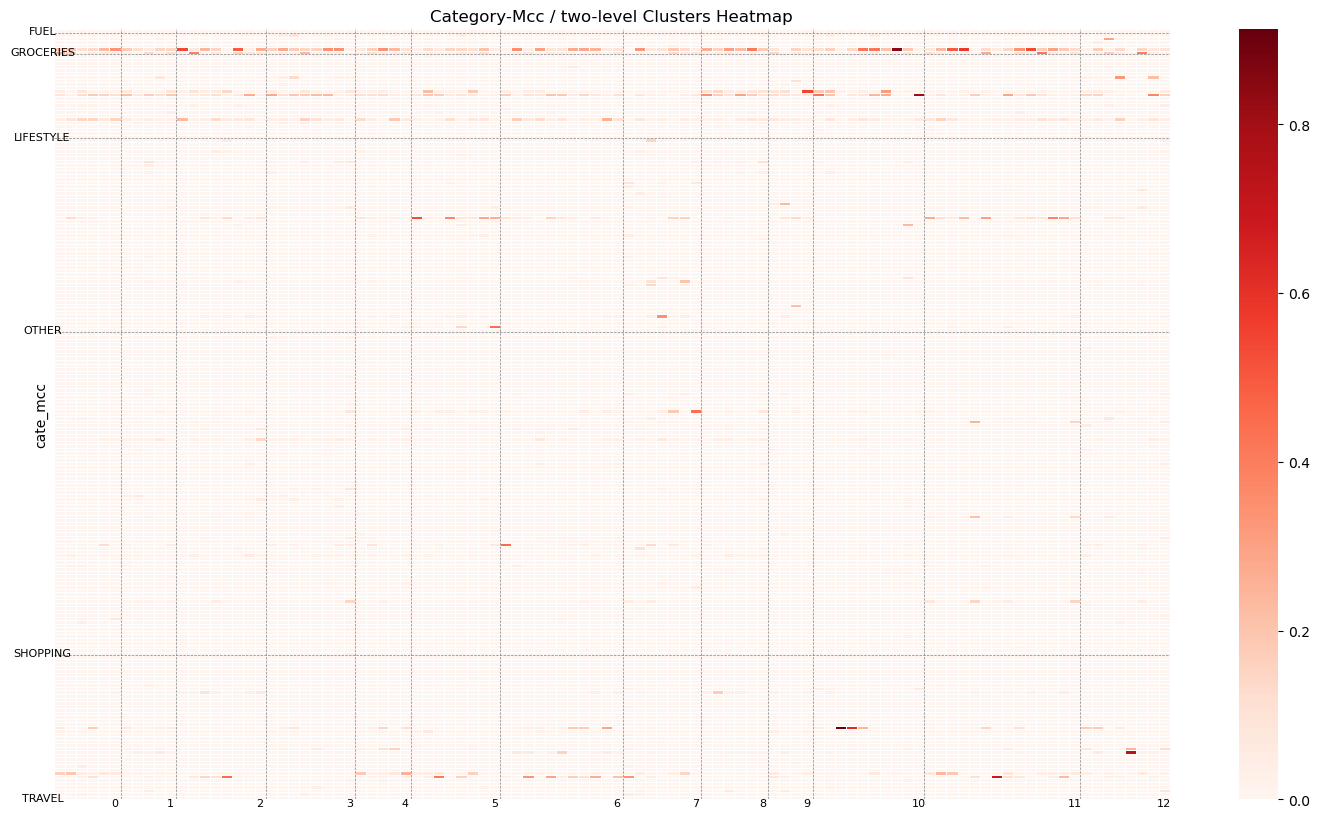

In [52]:
def two_level_heatmap(df_clusters, df, relative=False):
    cluster_counts = []

    # Get the normalized MCC transaction counts for each cluster
    for cluster in df_clusters['level'].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        filtered_df = df[df['level']==cluster]
        # calculate tfidf of each MCC
        if relative:
            mcc_counts_normalized = np.log(filtered_df['cate_mcc'].value_counts(normalize=True) / df_catemcc['proportion']).rename(cluster)
        else:
            mcc_counts_normalized = filtered_df['cate_mcc'].value_counts(normalize=True).rename(cluster)
        cluster_counts.append(mcc_counts_normalized)

    # Combine the normalized counts into a single DataFrame
    mcc_df_normalized = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # print(mcc_df_normalized.shape)
    # sort mcc by their category alphabetically
    mcc_df_normalized = mcc_df_normalized.reindex(sorted(mcc_df_normalized.index))
    
    # Create a heatmap
    plt.figure(figsize=(18, 10))
    if relative:
        sns.heatmap(mcc_df_normalized, cmap='PiYG', annot=False, fmt='.2f', linewidths=.5, vmin=-5, vmax=5, xticklabels=False, yticklabels=False)
    else:
        sns.heatmap(mcc_df_normalized, cmap='Reds', annot=False, fmt='.2%', linewidths=.5, xticklabels=False, yticklabels=False)
    # sns.heatmap(mcc_top_df_normalized, cmap='seismic', annot=True, fmt='.2f', linewidths=.5, vmin=-5, vmax=5)
    # highlight the category boundaries and the cluster boundaries
    for category, y in filtered_data.groupby('externalParty.transactionCategory')['MCC_List'].nunique().sort_index().cumsum().items():
        plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
        plt.text(-1, y-0.5, category, ha='center', va='center', fontsize=8)
    for level, x in df_clusters.groupby('level_1')['level_0'].nunique().sort_index().cumsum().items():
        plt.axvline(x=x, color='gray', lw=0.5, linestyle='--')
        plt.text(x-0.5, y+1, level, ha='center', va='center', fontsize=8)

    plt.title('Category-Mcc / two-level Clusters Heatmap')
    plt.show()

two_level_heatmap(df_clusters, filtered_data, relative=False)

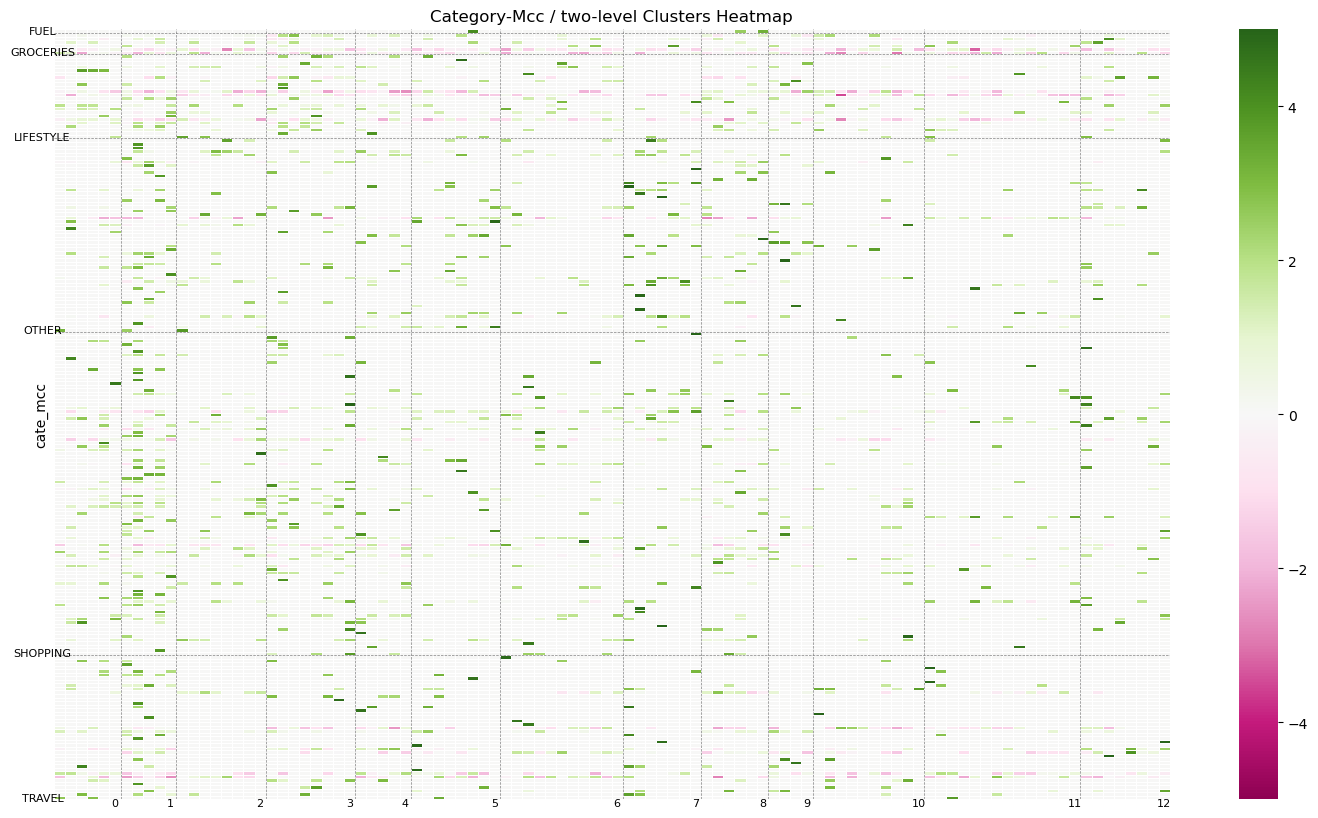

In [53]:
two_level_heatmap(df_clusters, filtered_data, relative=True)

In [264]:
filtered_data['MCC_List'].value_counts()

MCC_List
Grocery Stores and Supermarkets                                       4214
Eating Places and Restaurants                                         2604
Quick Payment Service-Fast Food Restaurants                           1257
Miscellaneous Food Stores-Convenience Stores and Specialty Markets    1240
Financial Institutions--Automated Cash Disbursements                  1218
                                                                      ... 
Stationery, Office Supplies, and Printing and Writing Paper              1
SN Brussels Airlines - SN BRUSSELS                                       1
Tax Payments                                                             1
Heating, Plumbing, Air Conditioning Contractors                          1
Emirates Airlines                                                        1
Name: count, Length: 199, dtype: int64

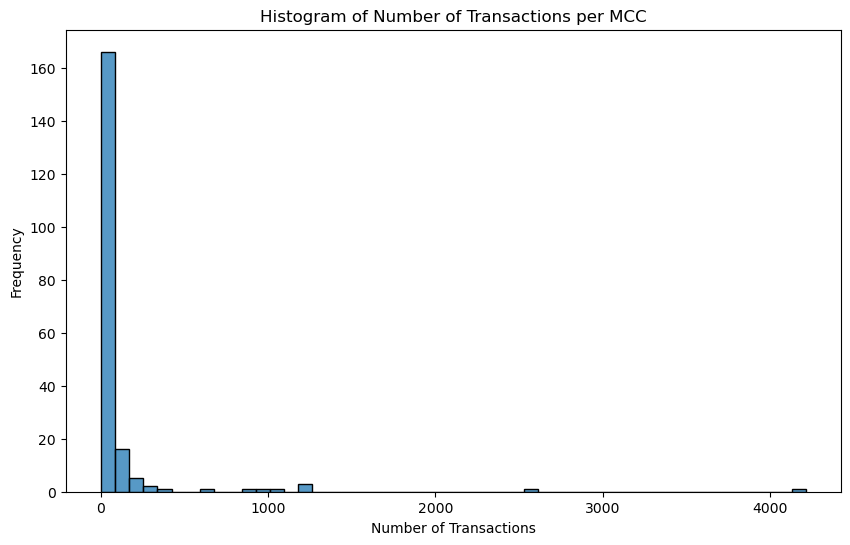

In [265]:
# plot the histogram of the number of transactions per mcc
plt.figure(figsize=(10,6))
sns.histplot(filtered_data['MCC_List'].value_counts(), bins=50)
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Transactions per MCC')
plt.show()

## Carbon emission Analysis

In [217]:
# calculate the average co2 emission per pound and total number of transaction for each customer
result = filtered_data.groupby('customerId').agg(total_co2 = ('transactionFootPrint.carbonEmissionInGrams', 'sum'),total_amount=('amount.value', 'sum'), transaction_count=('customerId', 'size'))
result['average_co2_per_pound'] = result['total_co2'] / result['total_amount']
# normalize the data
result['total_co2'] = (result['total_co2'] - result['total_co2'].mean()) / result['total_co2'].std()
result['total_amount'] = (result['total_amount'] - result['total_amount'].mean()) / result['total_amount'].std()
result['average_co2_per_pound'] = (result['average_co2_per_pound'] - result['average_co2_per_pound'].mean()) / result['average_co2_per_pound'].std()
result['transaction_count'] = (result['transaction_count'] - result['transaction_count'].mean()) / result['transaction_count'].std()
result.head()

total_co2  total_amount  \
customerId                                                      
01968de9-41cb-4509-b0a6-6bdc02700150   1.885294      2.513451   
01b34ce5-ce43-4c2d-a73d-5294376bd399  -0.083921     -0.122645   
01b4698f-32be-4bc0-9b69-b3024ac18004  -0.308146     -0.239822   
01ef943c-d661-48b0-9c0b-bb456a7d998d   0.031179     -0.190149   
03025a2b-9179-4da9-8dff-af4a3179ce7f  -0.074867      0.278659   

                                      transaction_count  average_co2_per_pound  
customerId                                                                      
01968de9-41cb-4509-b0a6-6bdc02700150           3.421743              -0.128694  
01b34ce5-ce43-4c2d-a73d-5294376bd399          -0.490151               0.026886  
01b4698f-32be-4bc0-9b69-b3024ac18004          -0.149342              -0.240190  
01ef943c-d661-48b0-9c0b-bb456a7d998d          -0.223431               0.398112  
03025a2b-9179-4da9-8dff-af4a3179ce7f           0.917538              -0.361719

In [213]:
# create a color map with 9 colors
colors = sns.color_palette('hsv', 9)
# create a color dictionary for the clusters, based on the customer_clusters
cluster_color_dict = {}
for i, cluster in enumerate(Customer_clusters):
    for customer in cluster:
        cluster_color_dict[customer] = colors[i]
cluster_color_dict

{'434a60bb-b98e-47e6-87e1-aa1bd913bde1': (1.0, 0.5790446966917554, 0.0),
 'fccc649d-a523-4f39-bc66-1e46a8ced7e5': (1.0, 0.5790446966917554, 0.0),
 'b88e862d-644e-40f3-af94-049cdb76c52e': (1.0, 0.5790446966917554, 0.0),
 'a3ba222c-b1a7-4686-bb63-539d43797376': (1.0, 0.5790446966917554, 0.0),
 '15182db2-b11c-4143-9dc5-f6ae29713936': (1.0, 0.5790446966917554, 0.0),
 'bfa3923b-5a03-4e9f-8301-7a65e681b068': (1.0, 0.5790446966917554, 0.0),
 '0ae40402-f81b-4ce1-801f-94246b674aef': (1.0, 0.5790446966917554, 0.0),
 '5b808c6c-9bc2-4298-8d4f-c1f4d3e46a95': (1.0, 0.5790446966917554, 0.0),
 '481427cb-72cb-4c84-8f19-03eee1f709b2': (1.0, 0.5790446966917554, 0.0),
 'a63ba1d5-c8ee-408b-ade5-b717cce075af': (1.0, 0.5790446966917554, 0.0),
 '7a2f20ea-5b1f-4582-a831-b6f44f06d148': (1.0, 0.5790446966917554, 0.0),
 'c3924705-b945-49a4-8cfd-00ac0e28b4ff': (1.0, 0.5790446966917554, 0.0),
 'bc417046-068f-49d2-bd29-ae34decc12fd': (1.0, 0.5790446966917554, 0.0),
 'd2f7ab36-24c1-4b3b-9002-8a6c46ae7fe8': (1.0, 0.57

In [218]:
# map the color dictionary to the customer_id in the result dataframe
result['color'] = result.index.map(cluster_color_dict)
result.head()

total_co2  total_amount  \
customerId                                                      
01968de9-41cb-4509-b0a6-6bdc02700150   1.885294      2.513451   
01b34ce5-ce43-4c2d-a73d-5294376bd399  -0.083921     -0.122645   
01b4698f-32be-4bc0-9b69-b3024ac18004  -0.308146     -0.239822   
01ef943c-d661-48b0-9c0b-bb456a7d998d   0.031179     -0.190149   
03025a2b-9179-4da9-8dff-af4a3179ce7f  -0.074867      0.278659   

                                      transaction_count  \
customerId                                                
01968de9-41cb-4509-b0a6-6bdc02700150           3.421743   
01b34ce5-ce43-4c2d-a73d-5294376bd399          -0.490151   
01b4698f-32be-4bc0-9b69-b3024ac18004          -0.149342   
01ef943c-d661-48b0-9c0b-bb456a7d998d          -0.223431   
03025a2b-9179-4da9-8dff-af4a3179ce7f           0.917538   

                                      average_co2_per_pound  \
customerId                                                    
01968de9-41cb-4509-b0a6-6bdc02700150              -0.128694   
01b34ce5-ce43-4c2d-a73d-5294376bd399               0.026886   
01b4698f-32be-4bc0-9b69-b3024ac18004              -0.240190   
01ef943c-d661-48b0-9c0b-bb456a7d998d               0.398112   
03025a2b-9179-4da9-8dff-af4a3179ce7f              -0.361719   

                                                                color  
customerId                                                             
01968de9-41cb-4509-b0a6-6bdc02700150  (0.23970412205706326, 1.0, 0.0)  
01b34ce5-ce43-4c2d-a73d-5294376bd399  (0.14595412205706287, 0.0, 1.0)  
01b4698f-32be-4bc0-9b69-b3024ac18004  (0.14595412205706287, 0.0, 1.0)  
01ef943c-d661-48b0-9c0b-bb456a7d998d   (0.0, 1.0, 0.9647031631761764)  
03025a2b-9179-4da9-8dff-af4a3179ce7f   (0.0, 1.0, 0.3625004724974957)

In [220]:
colors

[(1.0, 0.5790446966917554, 0.0),
 (0.8187488187488188, 1.0, 0.0),
 (0.23970412205706326, 1.0, 0.0),
 (0.0, 1.0, 0.3625004724974957),
 (0.0, 1.0, 0.9647031631761764),
 (0.0, 0.4562523625023627, 1.0),
 (0.14595412205706287, 0.0, 1.0),
 (0.724998818748819, 0.0, 1.0),
 (1.0, 0.0, 0.6727946966917553)]

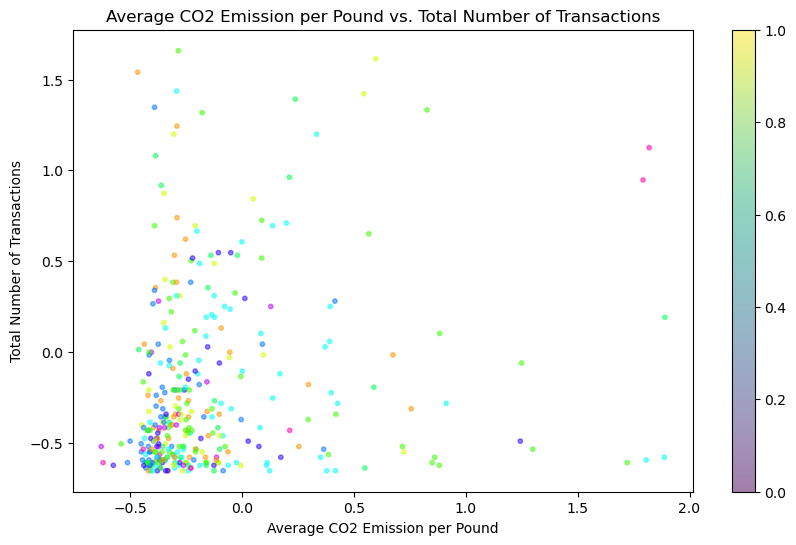

In [225]:
# plot each customer on a scatter plot with x-axis as the average co2 emission per pound and y-axis as the total number of transaction, color by the cluster
plt.figure(figsize=(10, 6))
# create a scatter plot
df_plot = result[(result['transaction_count'] < 2)&(result['average_co2_per_pound'] < 2)]
plt.scatter(df_plot['average_co2_per_pound'], df_plot['transaction_count'], c=df_plot['color'], alpha=0.5, s=10)
plt.xlabel('Average CO2 Emission per Pound')
plt.ylabel('Total Number of Transactions')
plt.title('Average CO2 Emission per Pound vs. Total Number of Transactions')
plt.colorbar()
plt.show()